# Macro Regimes Analysis - Exploratory Notebook
## Interactive Data Exploration & Sensitivity Analysis

**Purpose:** This notebook allows interactive exploration of regime classification, performance metrics, and scenario analysis.

**Contents:**
1. Data Loading & Inspection
2. Regime Analysis
3. Performance Metrics
4. Correlation Dynamics
5. Rate Shock Scenarios
6. Sensitivity Analysis

---

## Setup & Imports

In [29]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Add project modules to path
import sys
sys.path.insert(0, '..')

from config import Config
from src.data_acquisition import DataAcquisition
from src.regime_classifier import RegimeClassifier
from src.performance_analyzer import PerformanceAnalyzer
from src.scenario_analysis import RateShockAnalyzer

print("✓ Imports successful")

✓ Imports successful


## 1. Data Loading

In [30]:
# Load processed data (generated by main.py)
data = pd.read_csv('../data/processed/combined_data.csv', index_col=0, parse_dates=True)

print(f"Dataset shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"\nColumns: {list(data.columns)}")

# Display first few rows
data.head()

Dataset shape: (5062, 6)
Date range: 2004-11-18 00:00:00 to 2024-12-30 00:00:00

Columns: ['GLD', 'SPY', 'TLT', 'VIX', 'FED_FUNDS', 'TREASURY_10Y']


,GLD,SPY,TLT,VIX,FED_FUNDS,TREASURY_10Y
2004-11-18,44.380001,80.169022,44.820633,12.98,1.99,4.12
2004-11-19,44.779999,79.277824,44.462955,13.50,1.99,4.20
2004-11-22,44.950001,79.655884,44.694672,12.97,2.01,4.18
2004-11-23,44.750000,79.777458,44.750099,12.67,2.00,4.19
2004-11-24,45.049999,79.966492,44.750099,12.72,2.02,4.20


In [31]:
# Summary statistics
data.describe()

,GLD,SPY,TLT,VIX,FED_FUNDS,TREASURY_10Y
count,5062.000000,5062.000000,5062.000000,5062.000000,5062.000000,5062.000000
mean,127.209433,205.359143,83.728420,19.115215,1.687238,2.914218
std,43.957080,132.995392,25.107865,8.771119,1.936588,1.124061
min,41.259998,49.944592,43.552616,9.140000,0.040000,0.520000
25%,103.094997,96.954319,60.078648,13.302500,0.120000,2.012500
50%,123.430000,164.019493,86.138706,16.620001,0.405000,2.770000
75%,162.065006,272.540405,98.732075,22.207500,2.990000,3.860000
max,257.500000,598.740112,145.935471,82.690002,5.410000,5.260000


## 2. Regime Analysis

In [32]:
# If data doesn't have regimes, classify them
if 'REGIME' not in data.columns:
    print("Classifying regimes...")
    config = Config()
    classifier = RegimeClassifier(data, config)
    data = classifier.classify_regimes()

# Regime distribution
regime_counts = data['REGIME'].value_counts()
regime_pcts = (regime_counts / len(data) * 100).round(1)

print("Regime Distribution:")
for regime in ['TIGHTENING', 'EASING', 'STRESS', 'NORMAL']:
    if regime in regime_counts.index:
        print(f"  {regime:12s}: {regime_counts[regime]:5d} days ({regime_pcts[regime]:5.1f}%)")

Classifying regimes...
Classifying macro regimes...
✓ Regimes classified: 5062 days
  TIGHTENING  :  1989 days ( 39.3%)
  NORMAL      :  1211 days ( 23.9%)
  EASING      :  1014 days ( 20.0%)
  STRESS      :   848 days ( 16.8%)
Regime Distribution:
  TIGHTENING  :  1989 days ( 39.3%)
  EASING      :  1014 days ( 20.0%)
  STRESS      :   848 days ( 16.8%)
  NORMAL      :  1211 days ( 23.9%)


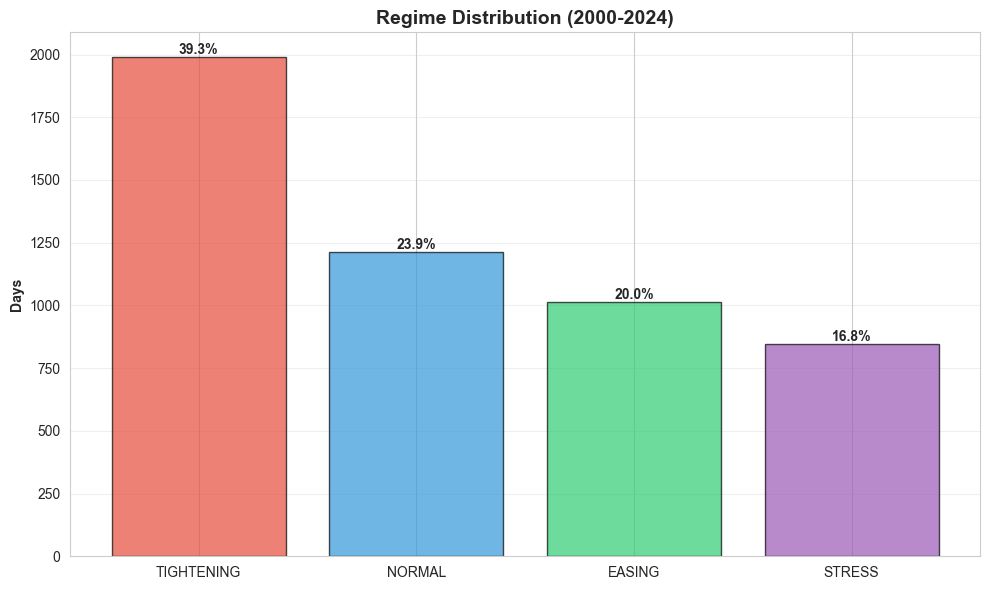

In [33]:
# Visualize regime distribution
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'TIGHTENING': '#e74c3c', 'EASING': '#2ecc71', 'STRESS': '#9b59b6', 'NORMAL': '#3498db'}
regime_colors = [colors[regime] for regime in regime_counts.index]

ax.bar(regime_counts.index, regime_counts.values, color=regime_colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Days', fontweight='bold')
ax.set_title('Regime Distribution (2000-2024)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (regime, count) in enumerate(regime_counts.items()):
    ax.text(i, count, f'{regime_pcts[regime]:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Asset Returns by Regime

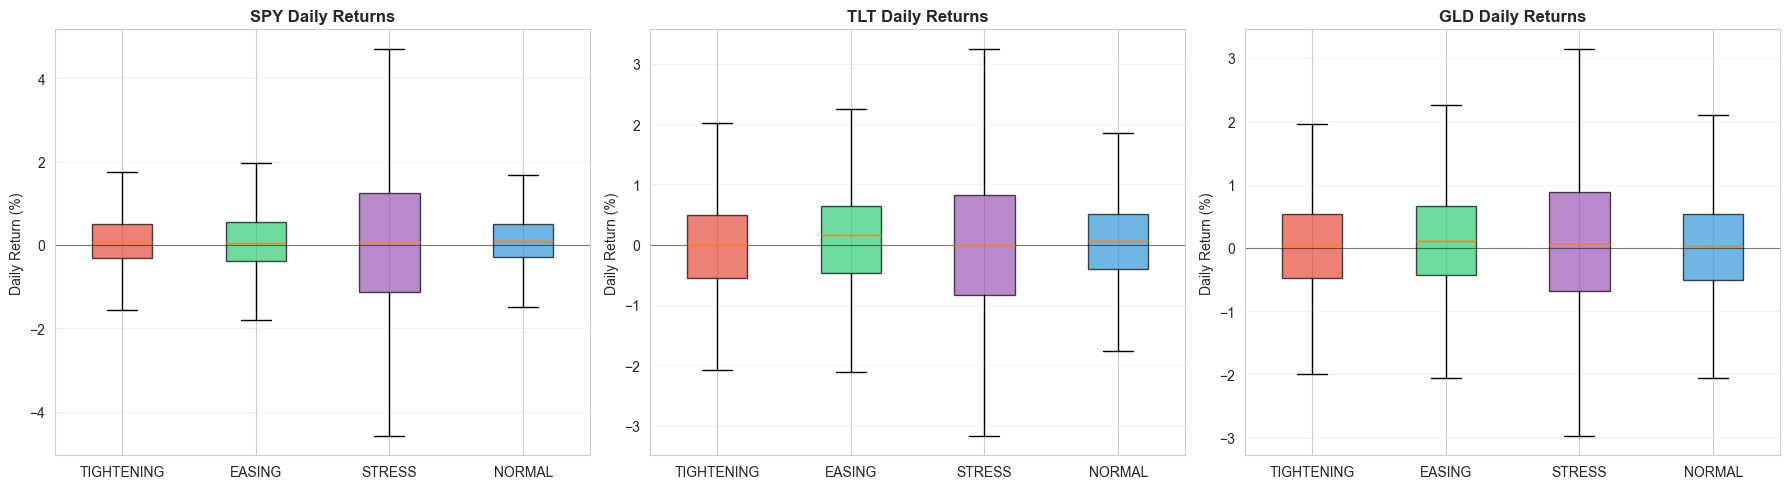

In [34]:
# Calculate returns if not present
for ticker in ['SPY', 'TLT', 'GLD']:
    if f'{ticker}_RET' not in data.columns and ticker in data.columns:
        data[f'{ticker}_RET'] = data[ticker].pct_change()

# Compare returns by regime
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

tickers = ['SPY', 'TLT', 'GLD']
regimes = ['TIGHTENING', 'EASING', 'STRESS', 'NORMAL']
colors = ['#e74c3c', '#2ecc71', '#9b59b6', '#3498db']

for idx, ticker in enumerate(tickers):
    ax = axes[idx]
    ret_col = f'{ticker}_RET'
    
    if ret_col in data.columns:
        data_to_plot = [data[data['REGIME'] == regime][ret_col].dropna() * 100 for regime in regimes]
        
        bp = ax.boxplot(data_to_plot, labels=regimes, patch_artist=True, showfliers=False)
        
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
        ax.set_title(f'{ticker} Daily Returns', fontweight='bold')
        ax.set_ylabel('Daily Return (%)')
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Correlation Dynamics

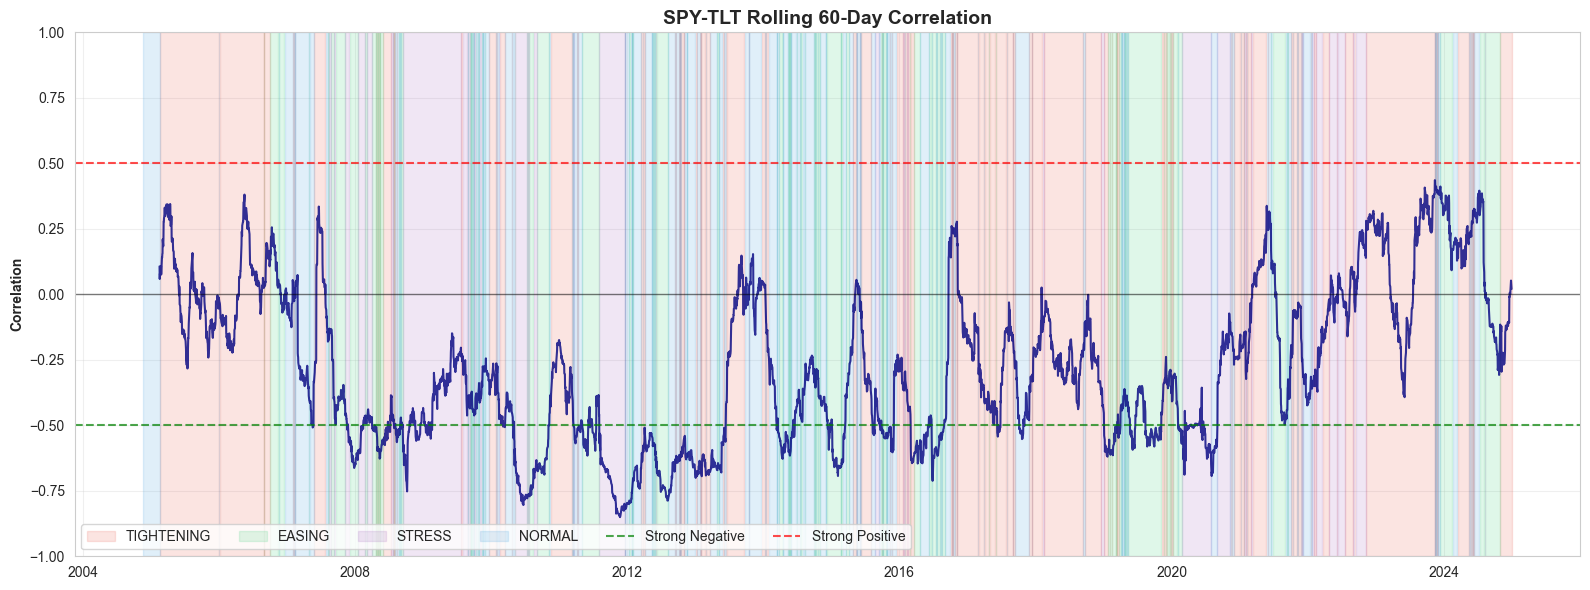

In [35]:
# Calculate rolling correlation if not present
if 'SPY_TLT_CORR' not in data.columns:
    window = 60
    data['SPY_TLT_CORR'] = data['SPY_RET'].rolling(window=window).corr(data['TLT_RET'])

# Plot correlation by regime
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(data.index, data['SPY_TLT_CORR'], color='navy', linewidth=1.5, alpha=0.8)

# Add regime background shading
colors = {'TIGHTENING': '#e74c3c', 'EASING': '#2ecc71', 'STRESS': '#9b59b6', 'NORMAL': '#3498db'}
for regime, color in colors.items():
    mask = data['REGIME'] == regime
    if mask.any():
        ax.fill_between(data.index, -1, 1, where=mask, alpha=0.15, color=color, label=regime)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.axhline(y=-0.5, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Strong Negative')
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Strong Positive')

ax.set_ylabel('Correlation', fontweight='bold')
ax.set_title('SPY-TLT Rolling 60-Day Correlation', fontsize=14, fontweight='bold')
ax.set_ylim(-1, 1)
ax.legend(loc='lower left', ncol=6, frameon=True)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
# Correlation statistics by regime
corr_by_regime = data.groupby('REGIME')['SPY_TLT_CORR'].agg(['mean', 'std', 'min', 'max']).round(3)
print("SPY-TLT Correlation by Regime:")
corr_by_regime

SPY-TLT Correlation by Regime:


,mean,std,min,max
REGIME,,,,
EASING,-0.409,0.280,-0.796,0.411
NORMAL,-0.354,0.281,-0.820,0.436
STRESS,-0.409,0.252,-0.851,0.245
TIGHTENING,-0.125,0.252,-0.806,0.434


## 5. Macro Variable Evolution

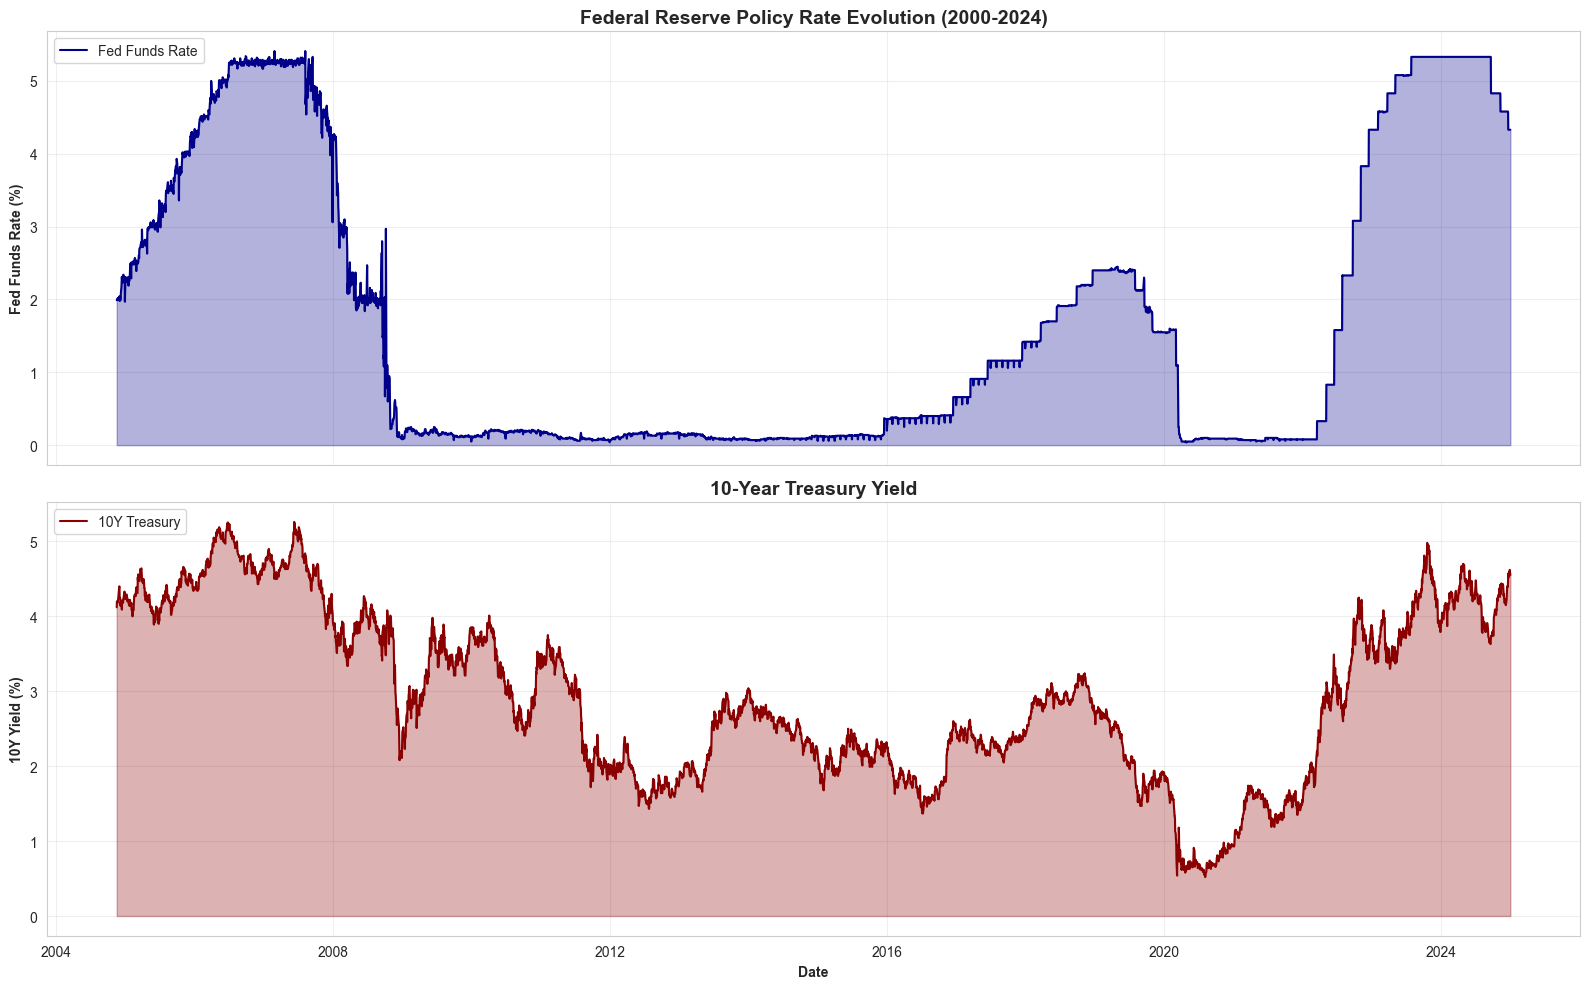

In [37]:
# Plot Fed Funds and 10Y Treasury over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Fed Funds Rate
ax1.plot(data.index, data['FED_FUNDS'], color='darkblue', linewidth=1.5, label='Fed Funds Rate')
ax1.fill_between(data.index, 0, data['FED_FUNDS'], alpha=0.3, color='darkblue')
ax1.set_ylabel('Fed Funds Rate (%)', fontweight='bold')
ax1.set_title('Federal Reserve Policy Rate Evolution (2000-2024)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# 10Y Treasury Yield
ax2.plot(data.index, data['TREASURY_10Y'], color='darkred', linewidth=1.5, label='10Y Treasury')
ax2.fill_between(data.index, 0, data['TREASURY_10Y'], alpha=0.3, color='darkred')
ax2.set_ylabel('10Y Yield (%)', fontweight='bold')
ax2.set_xlabel('Date', fontweight='bold')
ax2.set_title('10-Year Treasury Yield', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sensitivity Analysis

Test how regime classification changes with different thresholds

In [38]:
# Test different rate change thresholds
thresholds = [0.10, 0.15, 0.20, 0.25, 0.30]
regime_distributions = []

for threshold in thresholds:
    # Create temporary config
    test_config = Config()
    test_config.RATE_CHANGE_THRESHOLD = threshold
    
    # Classify regimes
    classifier = RegimeClassifier(data.copy(), test_config)
    test_data = classifier.classify_regimes()
    
    # Get distribution
    regime_counts = test_data['REGIME'].value_counts()
    regime_pcts = (regime_counts / len(test_data) * 100).round(1)
    
    regime_distributions.append({
        'Threshold': f'{threshold:.2f}',
        'TIGHTENING': regime_pcts.get('TIGHTENING', 0),
        'EASING': regime_pcts.get('EASING', 0),
        'STRESS': regime_pcts.get('STRESS', 0),
        'NORMAL': regime_pcts.get('NORMAL', 0)
    })

sensitivity_df = pd.DataFrame(regime_distributions)
print("Regime Distribution Sensitivity to Rate Change Threshold:")
sensitivity_df

Classifying macro regimes...
✓ Regimes classified: 5062 days
  TIGHTENING  :  2344 days ( 46.3%)
  EASING      :  1242 days ( 24.5%)
  STRESS      :   848 days ( 16.8%)
  NORMAL      :   628 days ( 12.4%)
Classifying macro regimes...
✓ Regimes classified: 5062 days
  TIGHTENING  :  2182 days ( 43.1%)
  EASING      :  1099 days ( 21.7%)
  NORMAL      :   933 days ( 18.4%)
  STRESS      :   848 days ( 16.8%)
Classifying macro regimes...
✓ Regimes classified: 5062 days
  TIGHTENING  :  1989 days ( 39.3%)
  NORMAL      :  1211 days ( 23.9%)
  EASING      :  1014 days ( 20.0%)
  STRESS      :   848 days ( 16.8%)
Classifying macro regimes...
✓ Regimes classified: 5062 days
  NORMAL      :  1667 days ( 32.9%)
  TIGHTENING  :  1597 days ( 31.5%)
  EASING      :   950 days ( 18.8%)
  STRESS      :   848 days ( 16.8%)
Classifying macro regimes...
✓ Regimes classified: 5062 days
  NORMAL      :  2046 days ( 40.4%)
  TIGHTENING  :  1316 days ( 26.0%)
  EASING      :   852 days ( 16.8%)
  STRESS   

,Threshold,TIGHTENING,EASING,STRESS,NORMAL
0,0.10,46.3,24.5,16.8,12.4
1,0.15,43.1,21.7,16.8,18.4
2,0.20,39.3,20.0,16.8,23.9
3,0.25,31.5,18.8,16.8,32.9
4,0.30,26.0,16.8,16.8,40.4


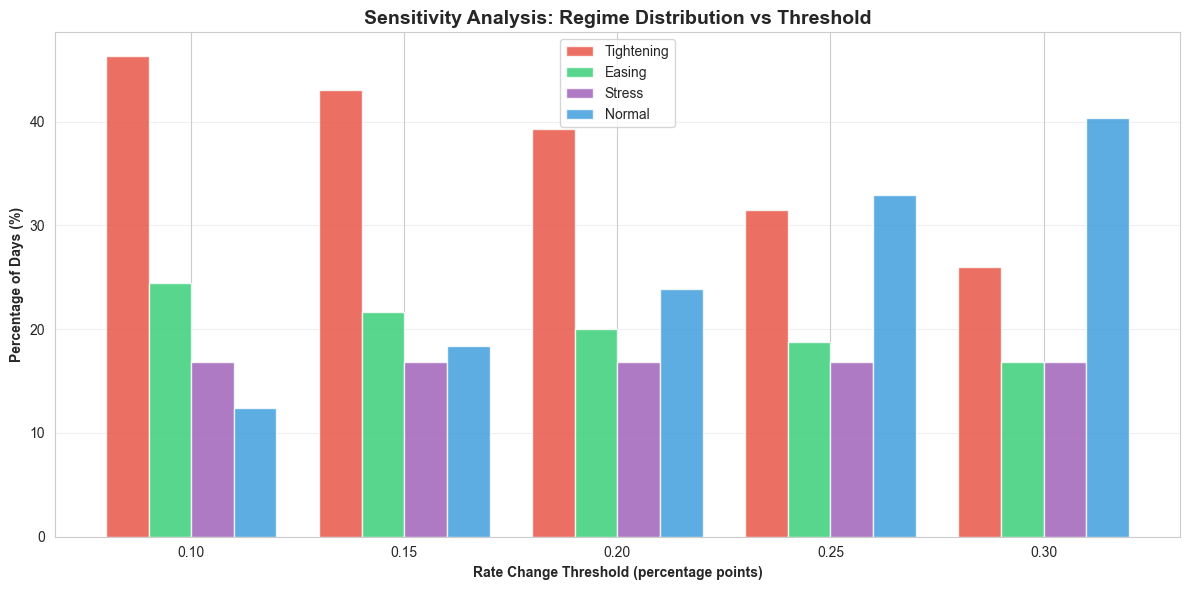

In [39]:
# Visualize sensitivity
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(thresholds))
width = 0.2

ax.bar([i - 1.5*width for i in x], sensitivity_df['TIGHTENING'], width, label='Tightening', color='#e74c3c', alpha=0.8)
ax.bar([i - 0.5*width for i in x], sensitivity_df['EASING'], width, label='Easing', color='#2ecc71', alpha=0.8)
ax.bar([i + 0.5*width for i in x], sensitivity_df['STRESS'], width, label='Stress', color='#9b59b6', alpha=0.8)
ax.bar([i + 1.5*width for i in x], sensitivity_df['NORMAL'], width, label='Normal', color='#3498db', alpha=0.8)

ax.set_ylabel('Percentage of Days (%)', fontweight='bold')
ax.set_xlabel('Rate Change Threshold (percentage points)', fontweight='bold')
ax.set_title('Sensitivity Analysis: Regime Distribution vs Threshold', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{t:.2f}' for t in thresholds])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Performance Metrics Deep Dive

In [40]:
# Load performance metrics
perf_df = pd.read_csv('../outputs/reports/performance_metrics.csv')

# Pivot for better visualization
perf_pivot = perf_df.pivot(index='Asset', columns='Regime', values='Ann_Return_pct')
perf_pivot = perf_pivot[['TIGHTENING', 'EASING', 'STRESS', 'NORMAL']]

print("Annualized Returns by Regime (%):")
perf_pivot

Annualized Returns by Regime (%):


Regime,TIGHTENING,EASING,STRESS,NORMAL
Asset,,,,
GLD,4.81,32.20,15.10,-3.82
SPY,12.26,7.21,8.40,16.75
TLT,-6.72,24.49,0.66,7.73


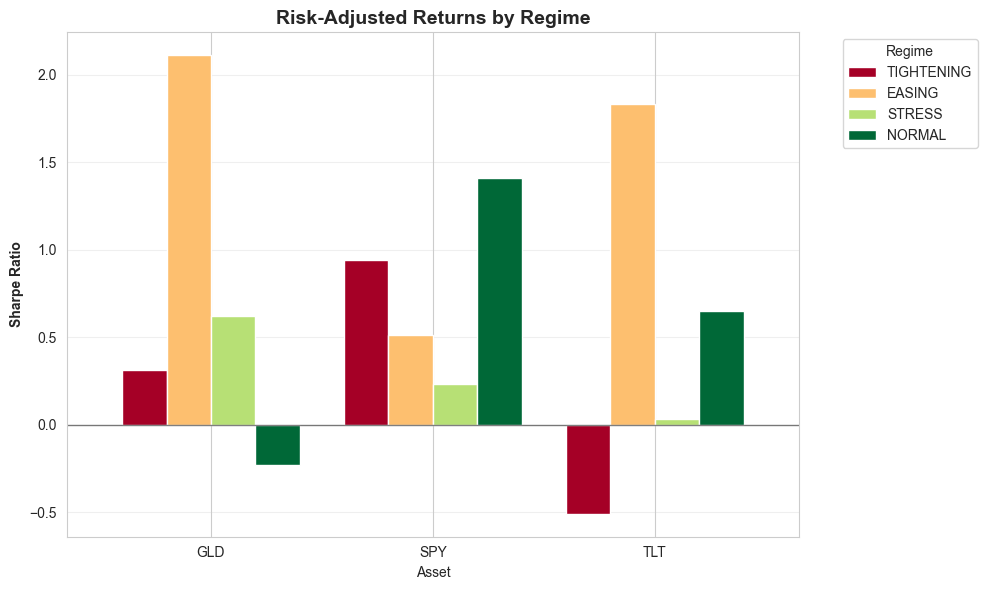

In [41]:
# Visualize Sharpe ratios
sharpe_pivot = perf_df.pivot(index='Asset', columns='Regime', values='Sharpe')
sharpe_pivot = sharpe_pivot[['TIGHTENING', 'EASING', 'STRESS', 'NORMAL']]

fig, ax = plt.subplots(figsize=(10, 6))
sharpe_pivot.plot(kind='bar', ax=ax, width=0.8, colormap='RdYlGn')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_ylabel('Sharpe Ratio', fontweight='bold')
ax.set_title('Risk-Adjusted Returns by Regime', fontsize=14, fontweight='bold')
ax.set_xlabel('Asset')
ax.legend(title='Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 8. Rate Shock Scenario Exploration

In [42]:
# Run rate shock analysis
config = Config()
shock_analyzer = RateShockAnalyzer(data, config)

shock_dates = shock_analyzer.identify_shocks()
shock_responses = shock_analyzer.measure_shock_response(shock_dates)

print(f"Found {len(shock_dates)} historical rate shock events")
shock_responses

Identifying historical rate shocks...
✓ Identified 4 rate shock events:
  2009-01-29: 10Y Yield = 2.87% (+0.74% over 21 days)
  2010-12-14: 10Y Yield = 3.49% (+0.73% over 21 days)
  2022-04-05: 10Y Yield = 2.54% (+0.76% over 21 days)
  2022-10-20: 10Y Yield = 4.24% (+0.73% over 21 days)
Measuring 63-day forward returns...
  ✓ 2009-01-29: Returns measured
  ✓ 2010-12-14: Returns measured
  ✓ 2022-04-05: Returns measured
  ✓ 2022-10-20: Returns measured
✓ Shock responses measured: 4 events
Found 4 historical rate shock events


,shock_date,start_yield,end_yield,SPY_ret,TLT_ret,GLD_ret
0,2009-01-29,2.87,3.16,4.134497,-4.971414,-2.491624
1,2010-12-14,3.49,3.22,1.743475,2.982964,0.044069
2,2022-04-05,2.54,3.01,-13.382637,-10.979508,-9.490074
3,2022-10-20,4.24,3.52,10.141959,12.214809,18.606807


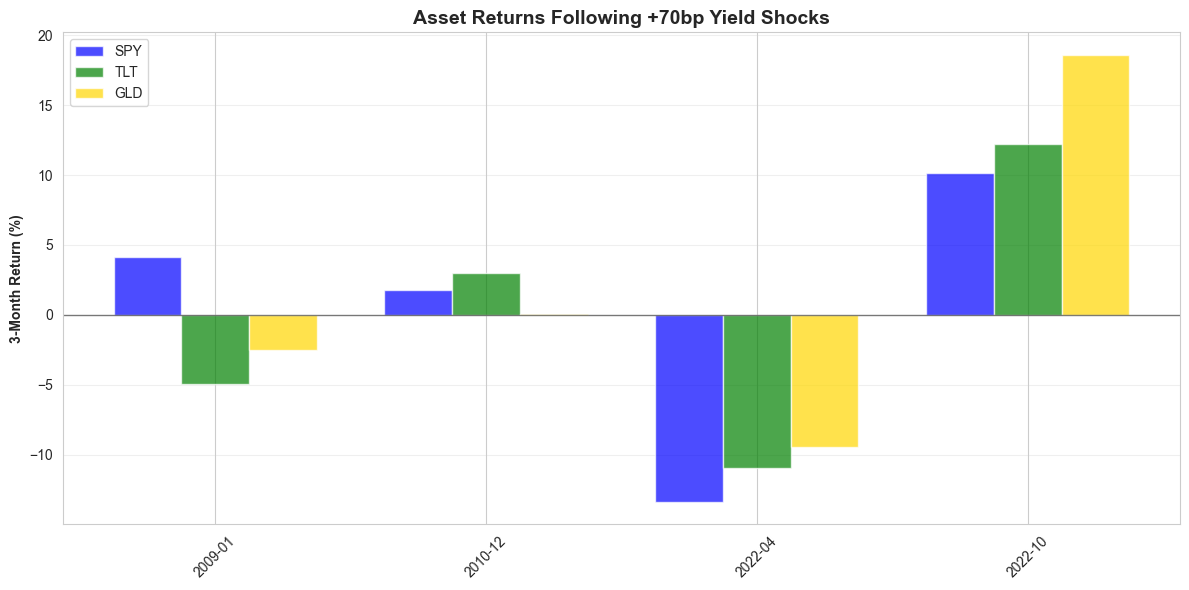

In [43]:
# Visualize individual shock responses
if len(shock_responses) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(shock_responses))
    width = 0.25
    
    ax.bar([i - width for i in x], shock_responses['SPY_ret'], width, label='SPY', color='blue', alpha=0.7)
    ax.bar(x, shock_responses['TLT_ret'], width, label='TLT', color='green', alpha=0.7)
    ax.bar([i + width for i in x], shock_responses['GLD_ret'], width, label='GLD', color='gold', alpha=0.7)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.set_ylabel('3-Month Return (%)', fontweight='bold')
    ax.set_title('Asset Returns Following +70bp Yield Shocks', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([d.strftime('%Y-%m') for d in shock_responses['shock_date']], rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Custom Analysis Section

Add your own analysis here!

In [44]:
# Example: Calculate drawdowns by regime
def calculate_drawdown(returns):
    cum_ret = (1 + returns).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    return drawdown

# SPY drawdowns by regime
for regime in ['TIGHTENING', 'EASING', 'STRESS', 'NORMAL']:
    regime_data = data[data['REGIME'] == regime]
    if len(regime_data) > 0 and 'SPY_RET' in regime_data.columns:
        dd = calculate_drawdown(regime_data['SPY_RET'].dropna())
        max_dd = dd.min() * 100
        print(f"{regime:12s}: Max Drawdown = {max_dd:.2f}%")

TIGHTENING  : Max Drawdown = -15.10%
EASING      : Max Drawdown = -25.05%
STRESS      : Max Drawdown = -45.23%
NORMAL      : Max Drawdown = -14.77%


## 10. Export Custom Analysis

Save any custom findings to CSV

In [45]:
# Example: Export regime transitions
regime_transitions = data[data['REGIME'] != data['REGIME'].shift(1)][['REGIME', 'FED_FUNDS', 'TREASURY_10Y']]
regime_transitions['PREV_REGIME'] = data['REGIME'].shift(1)[regime_transitions.index]

print(f"\nFound {len(regime_transitions)} regime transitions")
print("\nRecent transitions:")
regime_transitions.tail(10)


Found 390 regime transitions

Recent transitions:


,REGIME,FED_FUNDS,TREASURY_10Y,PREV_REGIME
2024-05-28,TIGHTENING,5.33,4.54,NORMAL
2024-06-03,NORMAL,5.33,4.41,TIGHTENING
2024-06-04,TIGHTENING,5.33,4.33,NORMAL
2024-06-05,NORMAL,5.33,4.29,TIGHTENING
2024-06-07,TIGHTENING,5.33,4.43,NORMAL
2024-06-12,NORMAL,5.33,4.31,TIGHTENING
2024-07-11,EASING,5.33,4.20,NORMAL
2024-08-07,STRESS,5.33,3.96,EASING
2024-08-12,EASING,5.33,3.90,STRESS
2024-10-30,TIGHTENING,4.83,4.29,EASING


In [46]:
# Save to CSV
# regime_transitions.to_csv('../outputs/reports/regime_transitions.csv')
# print("✓ Regime transitions saved")

---

## Next Steps

**For Further Development:**
1. Add credit spread analysis (HY OAS)
2. Incorporate Fed dot plot expectations
3. Build tactical allocation backtest
4. Add international markets (ECB, BoE)

---
